In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import seaborn as sns
import numpy as np
import squidpy as sq

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH = pathlib.Path(
    "/storage/groups/ml01/datasets/raw/20201214_SquidpyData_giovanni.palla/ionpath/"
)
DATA_PATH = ""

In [3]:
counts = pd.read_csv(BASE_PATH / "scMEP_MIBI_singlecell.csv")

In [4]:
molecules = counts.iloc[:, 3:39].copy()
metadata = pd.concat([counts.iloc[:, 0:3].copy(), counts.iloc[:, 39:].copy()], axis=1)
genes = molecules.columns.values

from anndata import AnnData
import scipy

molecules = scipy.sparse.csr_matrix(molecules.to_numpy())
molecules.eliminate_zeros()
adata = AnnData(molecules, obs=metadata)
adata.var_names = genes

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
metadata

row_num  point  cell_id       X1  center_rowcoord  center_colcoord  \
0            0      7        2  63894.0            109.0              6.0   
1            3      7        6  63898.0            845.0              5.0   
2            4      7        8  63900.0            997.0             17.0   
3            5      7        9  63901.0            192.0             13.0   
4            9      7       14  63906.0            913.0             17.0   
...        ...    ...      ...      ...              ...              ...   
63742    66394     25     1124  50571.0            890.0           1016.0   
63743    66395     25     1125  50572.0            492.0           1018.0   
63744    66396     25     1126  50573.0            618.0           1019.0   
63745    66397     25     1127  50574.0             65.0           1019.0   
63746    66398     25     1128  50575.0            933.0           1019.0   

       cell_size   category donor       Cluster  
0          277.0  carcinoma  90de     Imm_other  
1          298.0  carcinoma  90de     Imm_other  
2         2037.0  carcinoma  90de    Epithelial  
3          611.0  carcinoma  90de     Tcell_CD4  
4         1616.0  carcinoma  90de  Myeloid_CD68  
...          ...        ...   ...           ...  
63742      219.0  carcinoma  21d7     Imm_other  
63743      238.0  carcinoma  21d7     Tcell_CD4  
63744      283.0  carcinoma  21d7    Fibroblast  
63745      138.0  carcinoma  21d7   Endothelial  
63746      110.0  carcinoma  21d7     Imm_other  

[63747 rows x 10 columns]

In [6]:
adata.obsm["spatial"] = metadata[
    [
        "center_colcoord",
        "center_rowcoord",
    ]
].to_numpy()
adata = adata[adata.obs.point.isin([8, 16, 23])].copy()

In [7]:
import imageio

png8 = imageio.imread(BASE_PATH / "images/191001_cohort_Run-26_Point8_Overlay.png")
png16 = imageio.imread(BASE_PATH / "images/191001_cohort_Run-26_Point16_Overlay.png")
png23 = imageio.imread(BASE_PATH / "images/191001_cohort_Run-26_Point23_Overlay.png")

seg8 = imageio.imread(BASE_PATH / "segmentation/Point8_Label_Map.tiff")
seg16 = imageio.imread(BASE_PATH / "segmentation/Point16_Label_Map.tiff")
seg23 = imageio.imread(BASE_PATH / "segmentation/Point23_Label_Map.tiff")

In [8]:
spatial_key = "spatial"
adata.uns[spatial_key] = {}
for library_id, img, seg in zip(
    ["point8", "point16", "point23"], [png8, png16, png23], [seg8, seg16, seg23]
):
    adata.uns[spatial_key][library_id] = {}
    adata.uns[spatial_key][library_id]["images"] = {}
    adata.uns[spatial_key][library_id]["images"] = {"hires": img, "segmentation": seg}
    adata.uns[spatial_key][library_id]["scalefactors"] = {
        "tissue_hires_scalef": 1,
        "tissue_segmentation_scalef": 1,
        "spot_diameter_fullres": 15,
    }

In [9]:
adata.uns["spatial"].keys()

dict_keys(['point8', 'point16', 'point23'])

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'category' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cluster' as categorical


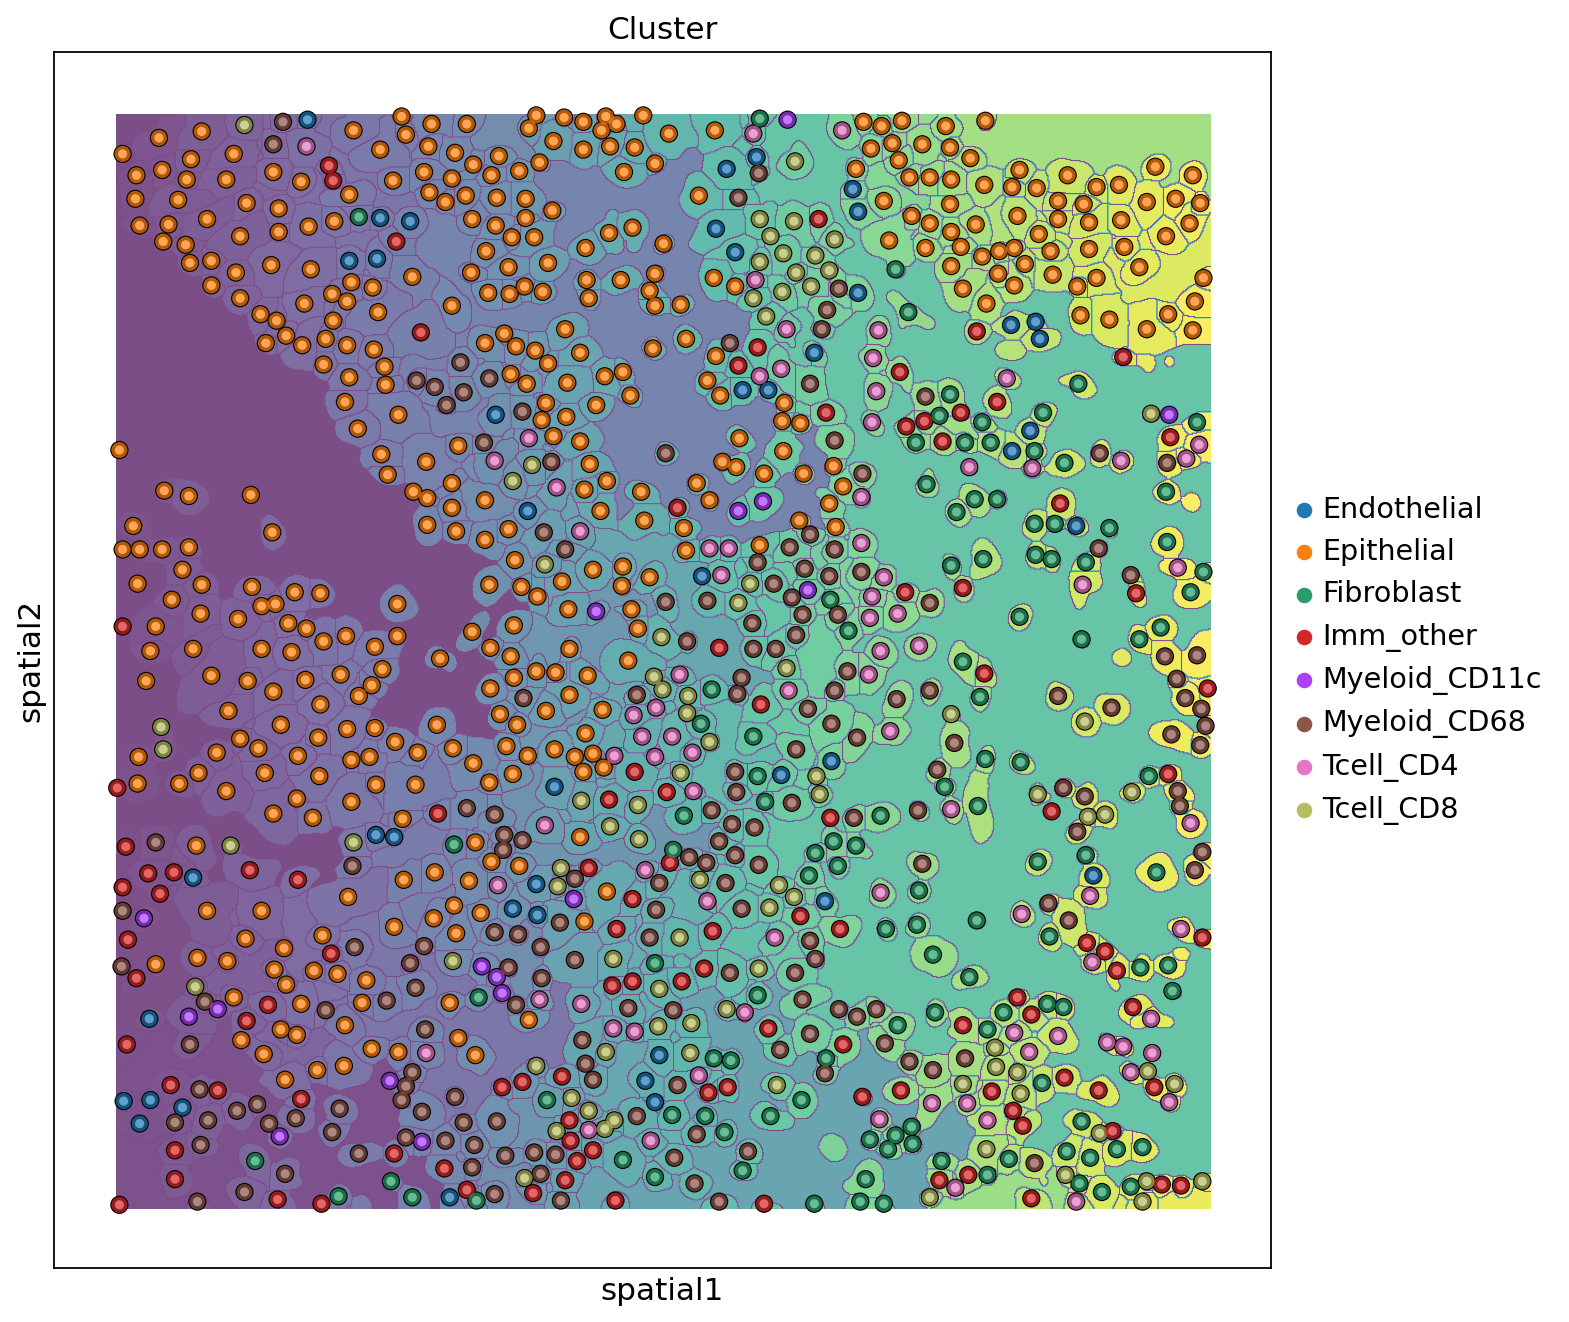

In [10]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.spatial(
    adata[adata.obs.point == 8],
    color="Cluster",
    library_id="point8",
    img_key="segmentation",
    alpha_img=0.7,
    add_outline=True,
    outline_width=(1.5, 1),
)

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'category' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cluster' as categorical


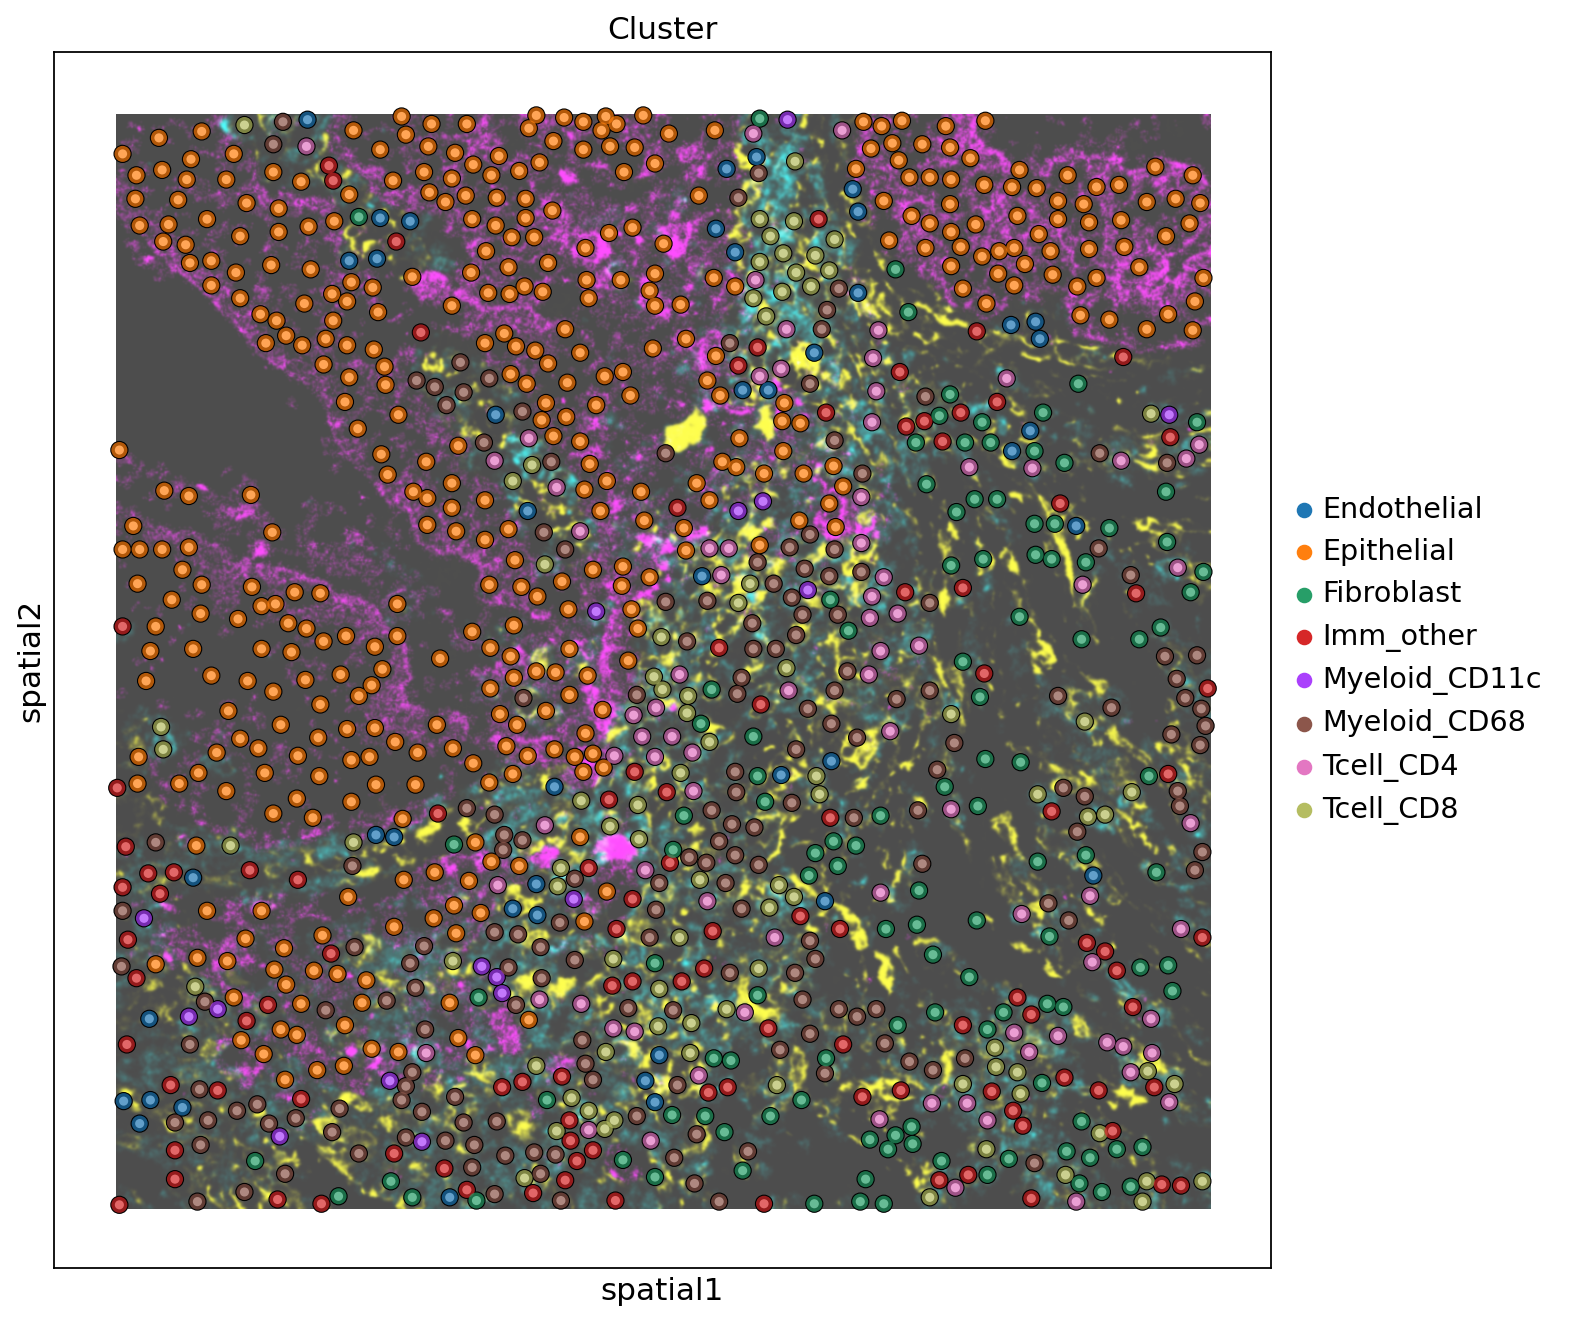

In [11]:
sc.pl.spatial(
    adata[adata.obs.point == 8],
    color="Cluster",
    library_id="point8",
    img_key="hires",
    alpha_img=0.7,
    add_outline=True,
    outline_width=(1.5, 1),
)

In [14]:
from scipy import sparse


def splitBatches(adata, batch, hvg=None):
    split = []
    if hvg is not None:
        adata = adata[:, hvg]
    for i in adata.obs[batch].unique():
        adata_split = adata[adata.obs[batch] == i].copy()
        adata_split.X = sparse.csr_matrix(adata_split.X.copy())
        sc.pp.scale(adata_split)
        split.append(adata_split)
    return split

In [15]:
import scanorama as scan

split = splitBatches(adata, batch="point")
corrected = scan.correct_scanpy(split, return_dimred=True)
corrected = corrected[0].concatenate(corrected[1], corrected[2])
adata = corrected.copy()

Found 36 genes among all datasets
[[0.         0.87832393 0.80983078]
 [0.         0.         0.93352884]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


In [16]:
adata.obsm

AxisArrays with keys: spatial, X_scanorama

In [17]:
sc.pp.neighbors(adata, use_rep="X_scanorama")
sc.tl.umap(adata)

... storing 'category' as categorical
... storing 'donor' as categorical
... storing 'Cluster' as categorical


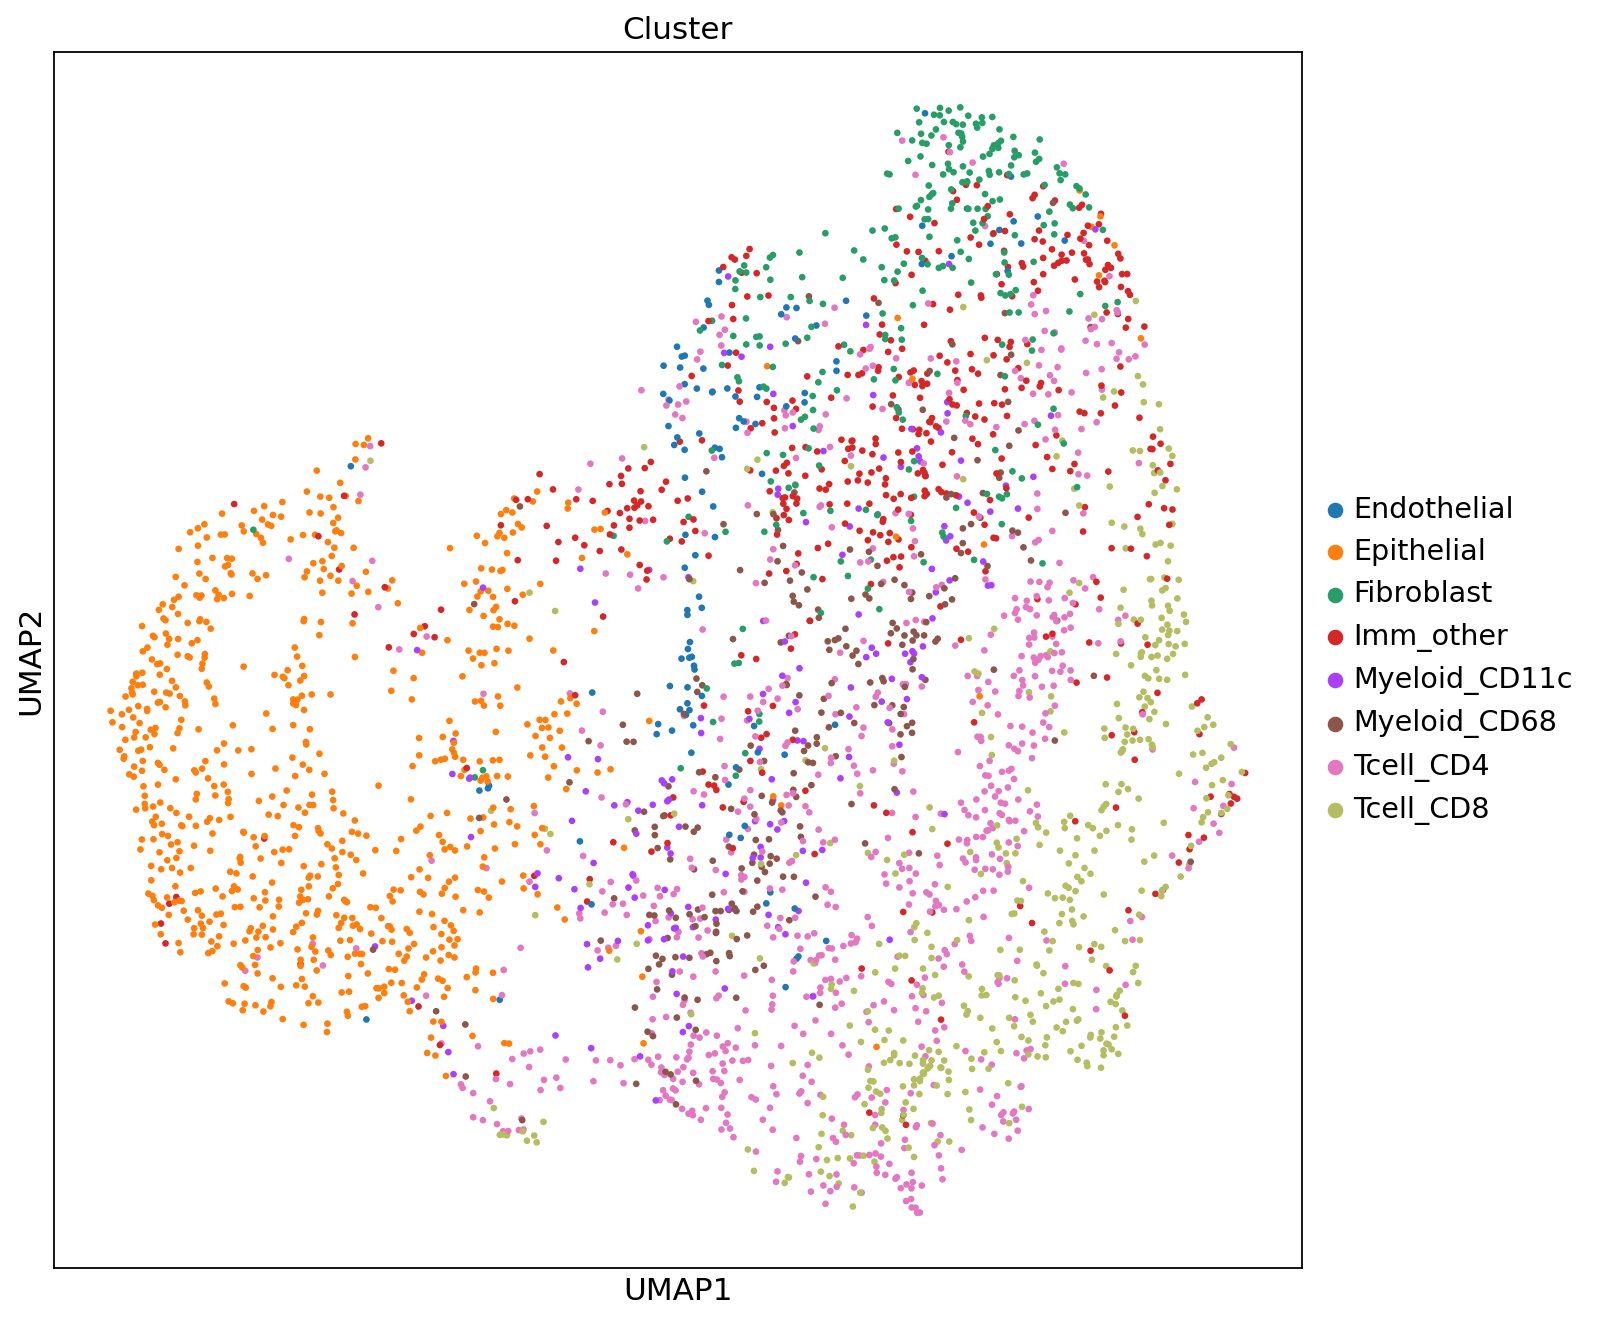

In [18]:
sc.pl.umap(adata, color="Cluster")

In [19]:
img8 = sq.im.ImageContainer(
    BASE_PATH / "images/191001_cohort_Run-26_Point16_Overlay.png"
)

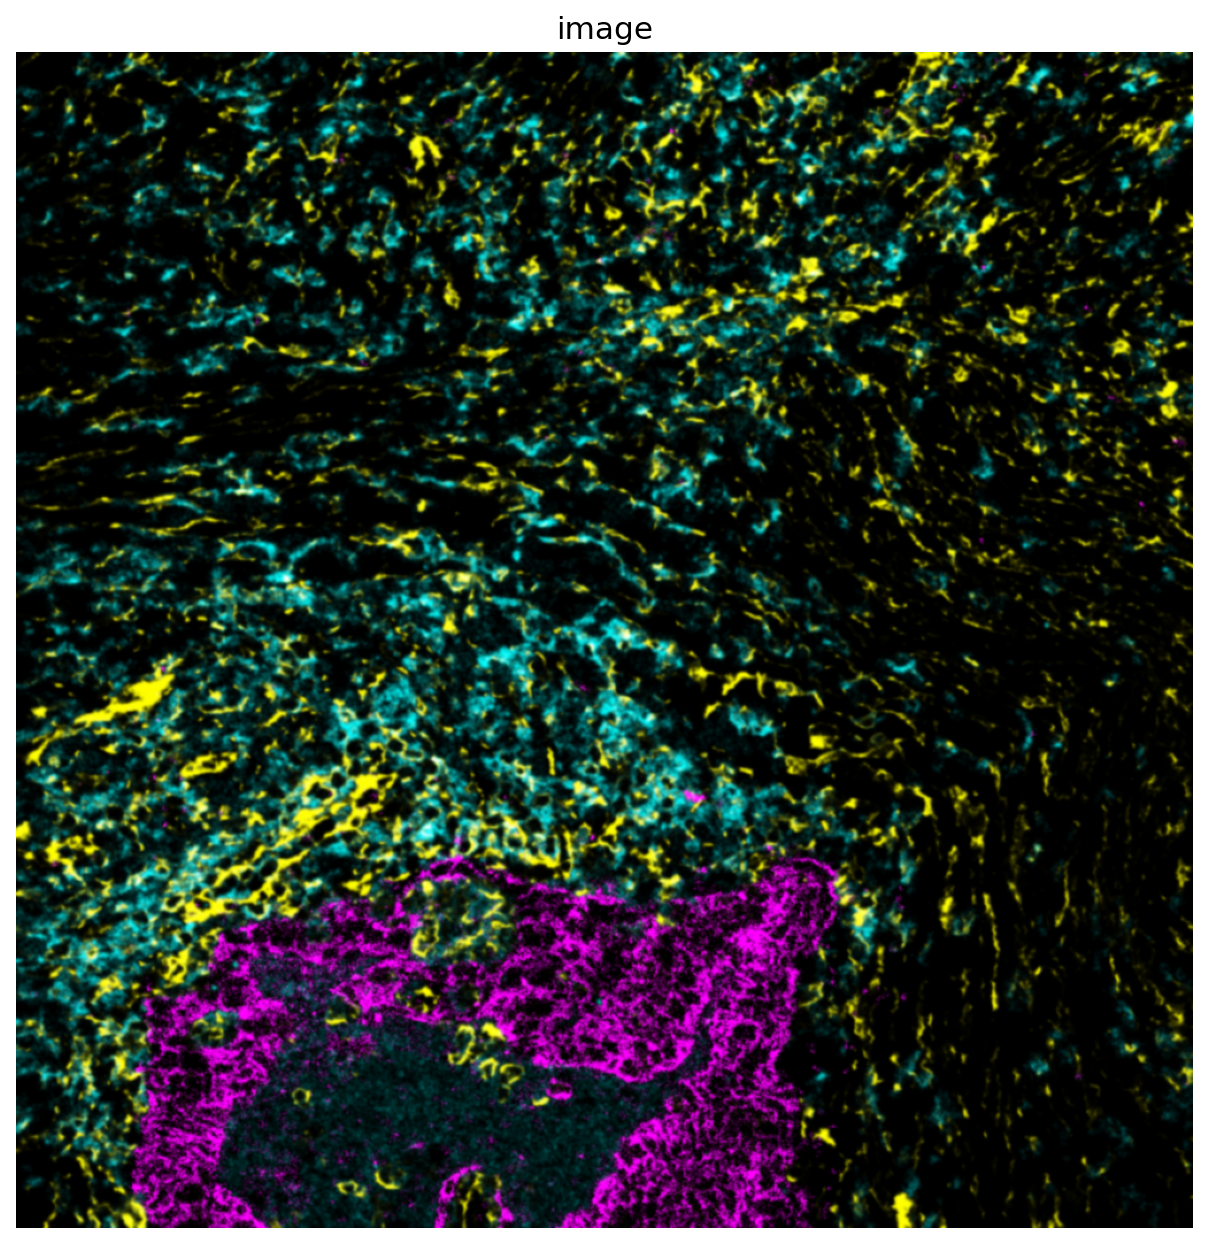

In [21]:
img8.show()

In [2]:
# naopari doesn't work on cluster
# import napari
# with napari.gui_qt():
#     img8.interactive(adata[adata.obs.point == 8])

In [22]:
adata.raw = adata

In [23]:
adata.write(
    "/storage/groups/ml01/datasets/raw/20201214_SquidpyData_giovanni.palla/tutorial_data/ionpath.h5ad"
)